In [40]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import truncnorm, norm

from bayesian_lista_src.tf.algorithms.ista.handler import IstaHandler
from bayesian_lista_src.tf.data.synthetic.data_generator import DataGenerator

from tqdm import trange

## Generative model

In [32]:
D = 10
K = 5
sparsity = 0.8
beta_scale = 1
noise_scale = 0.1

In [33]:
data_generator = DataGenerator(D=D, K=K, sparsity=sparsity, 
                beta_scale=beta_scale, noise_scale=noise_scale)

In [34]:
num_samples = 4
beta, y, Noise = data_generator.new_sample(N=num_samples)

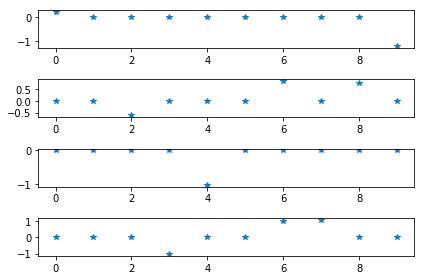

In [35]:
fig, ax = plt.subplots(4)
for i in range(num_samples):
    ax[i].plot(beta[i], '*')
plt.tight_layout()
plt.show()

## Existing models
### ISTA

In [37]:
initial_lambda = 0.2

In [38]:
handler = IstaHandler(D=D, K=K, L=L, X=data_generator.X.astype(np.float32), 
                      initial_lambda=initial_lambda)

In [41]:
num_epochs = 10
N = 1000
beta, y, Noise = data_generator.new_sample(N)
beta_valid, y_valid, _ = data_generator.new_sample(N)
loss_hist, valid_loss_hist = [], []
t = trange(100, desc='ML')
for i in t:
    prediction = handler.predict(y.astype(np.float32))
    loss = IstaHandler.loss(handler.model(y.astype(np.float32)), beta)
    valid_loss = IstaHandler.loss(handler.model(y_valid.astype(np.float32)), beta_valid)
    t.set_description(f'ML (loss={loss.numpy()}, valid_loss={valid_loss.numpy()})')
    loss_hist.append(loss.numpy())
    valid_loss_hist.append(valid_loss.numpy())

plt.plot(loss_hist)
plt.plot(valid_loss_hist)
plt.show()

beta_pred = handler.model(y_valid.astype(np.float32))
print(f'beta_valid_0: {beta_valid[0]}, beta_pred_0:{beta_pred[0]}')
print(f'beta_valid_10: {beta_valid[10]}, beta_pred_10:{beta_pred[10]}')

ML:   0%|          | 0/100 [00:00<?, ?it/s]

ValueError: operands could not be broadcast together with shapes (1000,10) (10,10) 

### Initialization

In [136]:
X_e = 1 / L * X.T
S = np.eye(K) - 1 / L * np.matmul(X.T, X)

### LISTA 0

In [137]:
B = np.matmul(X_e, y)
beta_cur = soft_threshold(B, thr_lambda)

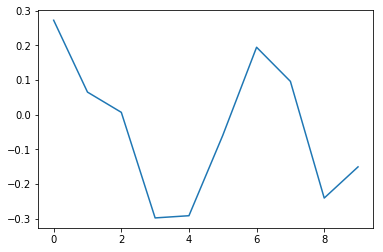

In [138]:
plt.plot(B)
plt.show()

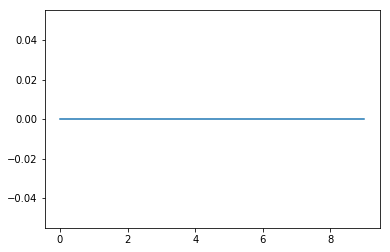

In [139]:
plt.plot(beta_cur)
plt.show()

In [140]:
test_s_thr = soft_threshold(np.linspace(-2, 2, 1000), 0.2)

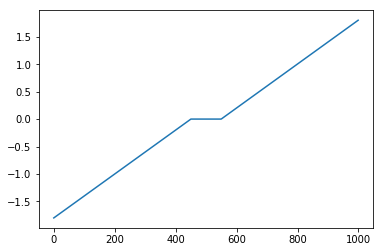

In [141]:
plt.plot(test_s_thr)
plt.show()

## LISTA T

In [142]:
for t in range(0, T):
    C = B + np.matmul(S, beta_cur)
    beta_cur = soft_threshold(C, thr_lambda)

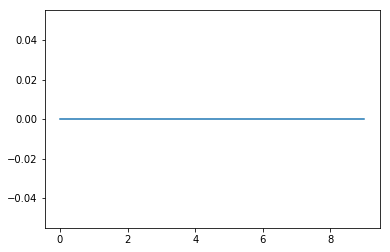

In [143]:
plt.plot(beta_cur)
plt.show()

# Propagate distributions

### Gaussian through soft-thresholding

In [144]:
sample_size = np.int(1e+6)

In [145]:
points = np.random.normal(loc=5.0, scale=1.0, size=sample_size)
points_propagated = soft_threshold(points, thr_lambda)

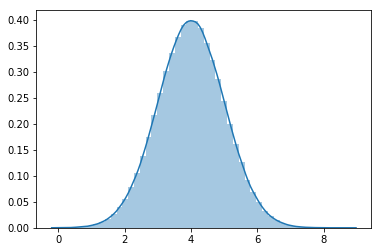

In [146]:
sns.distplot(points_propagated)
plt.show()

In [147]:
np.std(points_propagated[np.nonzero(points_propagated)])

0.9986915464192423

In [148]:
# compute the mean and variance of truncated distributions that will be approximated with slab

my_mean = 5.
my_std = 1.
infty = 1e+12

mean_right, var_right, skew, kurt = truncnorm.stats(
    a= (thr_lambda-my_mean) / my_std, 
    b= infty, 
    moments='mvsk')
mean_left, var_left, skew, kurt = truncnorm.stats(
    a= -infty, 
    b= (-thr_lambda-my_mean) / my_std, 
    moments='mvsk')

# slab
mean_approx = mean_left + mean_right
var_approx = var_left + var_right

# spike
omega = norm.cdf((thr_lambda - my_mean) / my_std) - norm.cdf((-thr_lambda - my_mean) / my_std)

# sample from resulting spike_and_slab
s_approx = np.random.normal(loc=mean_approx, scale=np.sqrt(var_approx), size=sample_size) * np.random.binomial(n=1, p=1-omega, size=sample_size)

In [149]:
np.sqrt(var_approx)

1.011658183884006

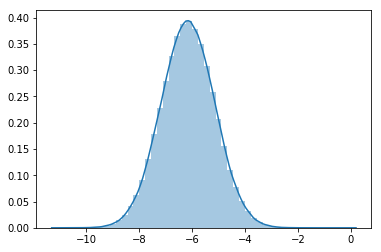

In [150]:
sns.distplot(s_approx)
plt.show()

In [151]:
def compute_slab_moments_for_thresholded_gaussian(mu, sigma2, thr_lambda):
    sigma = np.sqrt(sigma2)
    right_mean = sigma/np.sqrt(2*np.pi) * np.exp(-(thr_lambda-mu)**2/(2*sigma2)) + mu*(1-norm.cdf((thr_lambda-mu)/sigma))
    left_mean = -sigma/np.sqrt(2*np.pi) * np.exp(-(thr_lambda+mu)**2/(2*sigma2)) + mu*norm.cdf((-thr_lambda-mu)/sigma)
    right_2nd = sigma * (thr_lambda + mu)/np.sqrt(2*np.pi) * np.exp(-(thr_lambda-mu)**2/(2*sigma2)) + \
        (sigma2 + mu**2)*(1-norm.cdf((thr_lambda-mu)/sigma))
    left_2nd = sigma * (thr_lambda - mu)/np.sqrt(2*np.pi) * np.exp(-(thr_lambda+mu)**2/(2*sigma2)) + \
        (sigma2 + mu**2)*norm.cdf(-(thr_lambda+mu)/sigma)
    mean = right_mean + left_mean
    moment2 = right_2nd + left_2nd
    var = moment2 - mean ** 2
    return mean, var

In [152]:
mean_approx2, var_approx2 = compute_slab_moments_for_thresholded_gaussian(mu=5., sigma2=1., thr_lambda=thr_lambda)

In [153]:
thr_lambda

1

In [154]:
mean_approx2

4.999975472873654

In [155]:
var_approx2

1.000224801076552

In [156]:
omega

3.167025524547483e-05

In [157]:
s_approx2 = np.random.normal(loc=mean_approx2, scale=np.sqrt(var_approx2), size=sample_size) * \
np.random.binomial(n=1, p=1-omega, size=sample_size)

In [158]:
np.sqrt(var_approx2)

1.0001123942220453

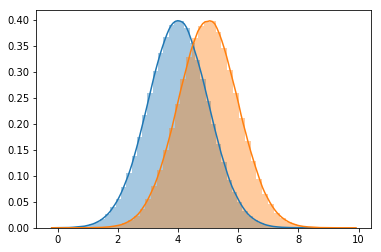

In [159]:
sns.distplot(points_propagated)
sns.distplot(s_approx2)
plt.show()